<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#AB-testing-for-two-variables" data-toc-modified-id="AB-testing-for-two-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>AB testing for two variables</a></span><ul class="toc-item"><li><span><a href="#Data-Generator" data-toc-modified-id="Data-Generator-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Generator</a></span></li><li><span><a href="#P-value-calculator" data-toc-modified-id="P-value-calculator-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>P value calculator</a></span></li><li><span><a href="#Experiment-runner" data-toc-modified-id="Experiment-runner-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Experiment runner</a></span></li></ul></li><li><span><a href="#AB-testing-for-more-than-two-variables" data-toc-modified-id="AB-testing-for-more-than-two-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>AB testing for more than two variables</a></span><ul class="toc-item"><li><span><a href="#Beta-Destribution-Scnarios" data-toc-modified-id="Beta-Destribution-Scnarios-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Beta Destribution Scnarios</a></span></li><li><span><a href="#Code-for-A/B-testing-using-Beta-Destribution" data-toc-modified-id="Code-for-A/B-testing-using-Beta-Destribution-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Code for A/B testing using Beta Destribution</a></span></li></ul></li><li><span><a href="#Convergence" data-toc-modified-id="Convergence-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Convergence</a></span></li><li><span><a href="#Confidence-Interval-Approximation-vs-Beta-Posterior" data-toc-modified-id="Confidence-Interval-Approximation-vs-Beta-Posterior-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Confidence Interval Approximation vs Beta Posterior</a></span></li></ul></div>

**Note**

Cython is a package that allow you to compile C in python, which is the major reason why numpy and pandas are fast. Make sure you has Cython install by doing

pip install cython 

You get instant double performance without changing any code at all! It’s great, but it isn’t amazing at all.

<img src="imgs/1_fZS2AARQeqPRyXWEM8DXhg.png" align="left"> 

## Imports

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2, beta, norm
%matplotlib inline

## AB testing for two variables

### Data Generator

In [3]:
class DataGenerator:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2

    def next(self):
        click1 = 1 if (np.random.random() < self.p1) else 0
        click2 = 1 if (np.random.random() < self.p2) else 0
        return click1, click2

### P value calculator

In [4]:
def get_p_value(T):
    det = T[0, 0]*T[1, 1] - T[1, 0]*T[0, 1]
    c2 = float(det) / T[0].sum() * det / T[1].sum() * \
        T.sum() / T[:, 0].sum() / T[:, 1].sum()
    p = 1 - chi2.cdf(x=c2, df=1)
    return p

### Experiment runner

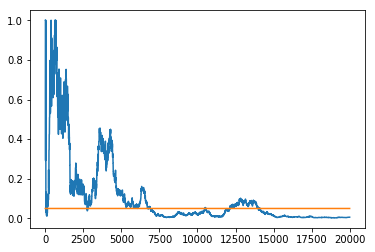

In [20]:
def run_experiment(p1, p2, N):
    data = DataGenerator(p1, p2)
    p_values = np.empty(N)
    T = np.zeros((2, 2)).astype(np.float32)
    for i in range(N):
        c1, c2 = data.next()
        T[0, c1] += 1
        T[1, c2] += 1
        if i < 10:
            p_values[i] = None
        else:
            p_values[i] = get_p_value(T)
    plt.plot(p_values)
    plt.plot(np.ones(N)*0.05)
    plt.show()


run_experiment(0.1, 0.11, 20000)

## AB testing for more than two variables

**Possible Ways**
* Pairwise testing
* One-vs-All(rest)

-----
**Terms**
1. Post Hoc Testing
2. Multi-Armed Bandit Problem
3. Epsilon Greedy
4. Chernoff-Hoeffding bound
5. UCB1 Algo 
6. Markov chain Monte Carlo (MCMC) : https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

### Beta Destribution Scnarios

<img src= "imgs/Annotation 2019-04-03 135829.png" width=600 height=400>
<img src= "imgs/Annotation 2019-04-03 140009.png" width=600 height=400>
<img src= "imgs/Annotation 2019-04-03 140018.png" width=600 height=400>
<img src= "imgs/Annotation 2019-04-03 140200.png" width=600 height=400>
<img src= "imgs/Annotation 2019-04-03 140255.png" width=600 height=400>

### Code for A/B testing using Beta Destribution

In [1]:
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]

In [11]:
class Bandit(object):
    def __init__(self, p):
        self.p = p
        self.a = 1
        self.b = 1

    def pull(self):
        return np.random.random() < self.p

    def sample(self):
        return np.random.beta(self.a, self.b)

    def update(self, x):
        self.a += x
        self.b += (1-x)

In [ ]:
def plot(bandits, trial):
    x = np.linspace(0, 1, 200)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label="real p: %.4f" % b.p)
    plt.title(f"Bandit distribution after {trial} trials")
    plt.legend()
    plt.show()

In [ ]:
def experiment():
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]
    sample_points = [5, 10, 20, 50, 100, 200, 500, 1000, 1500, 1999]

    for i in range(NUM_TRIALS):
        bestb = None
        maxsample = -1
        allsamples = []

        for b in bandits:
            sample = b.sample()
            allsamples.append("%.4f" % sample)
            if sample > maxsample:
                maxsample = sample
                bestb = b
        if i in sample_points:
            print(f"current samples:${allsamples}")
            # print("current samples: %s" % allsamples)
            plot(bandits, i)

        x = bestb.pull()

        bestb.update(x)

current samples:$['0.3490', '0.7138', '0.3729']


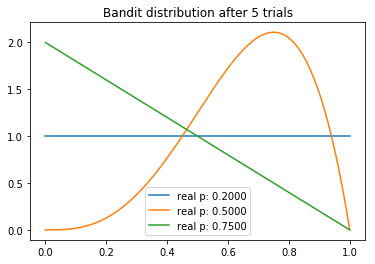

current samples:$['0.5912', '0.7775', '0.7055']


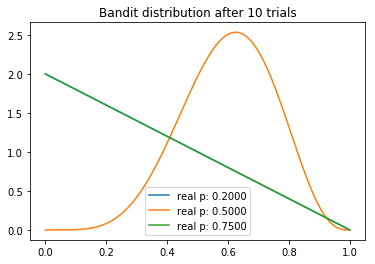

current samples:$['0.5688', '0.4932', '0.9038']


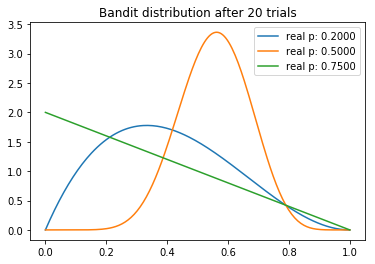

current samples:$['0.3787', '0.5880', '0.7100']


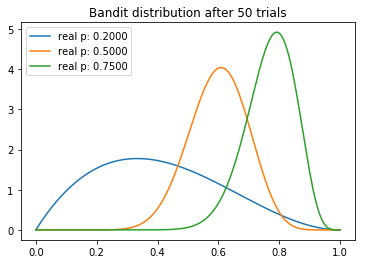

current samples:$['0.8560', '0.6366', '0.8123']


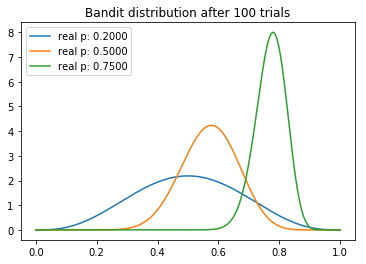

current samples:$['0.1407', '0.5435', '0.8007']


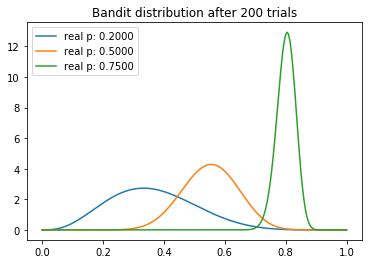

current samples:$['0.2654', '0.4874', '0.7326']


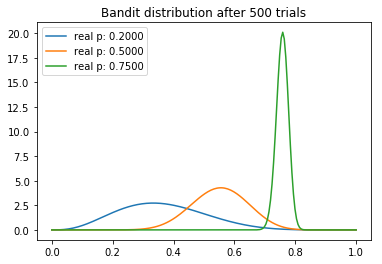

current samples:$['0.1900', '0.5922', '0.7592']


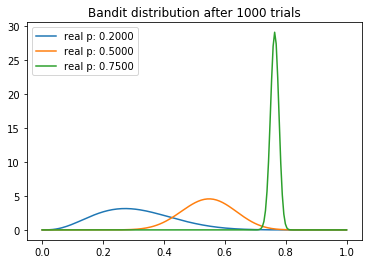

current samples:$['0.4793', '0.4630', '0.7625']


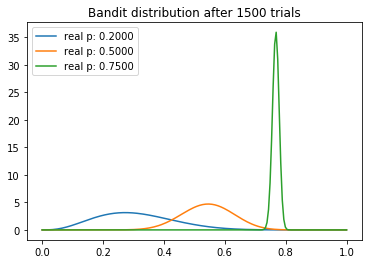

current samples:$['0.3858', '0.6470', '0.7660']


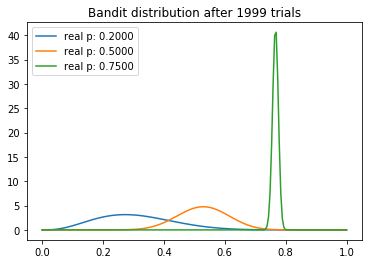

In [10]:
experiment()

## Convergence

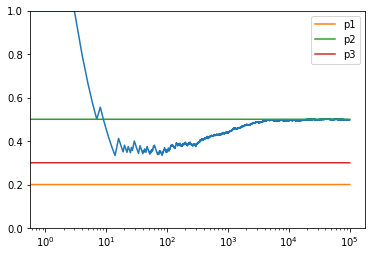

In [29]:
def run_experiment(p1,p2,p3, N):
    bandits = [Bandit(p1), Bandit(p2), Bandit(p3)]
    
    data = np.empty(N)
    
    for i in range(N):
        j = np.argmax([b.sample() for b in bandits])
        x= bandits[j].pull()
        bandits[j].update(x)
        
        data[i] = x
        
    cumelative_average_ctr = np.cumsum(data) / (np.arange(N) +1)
    plt.plot(cumelative_average_ctr)
    plt.plot(np.ones(N)*p1, label="p1")
    plt.plot(np.ones(N)*p2, label="p2")
    plt.plot(np.ones(N)*p3, label="p3")
    plt.ylim((0,1))
    plt.legend()
    plt.xscale('log')
    plt.show()
    
run_experiment(0.2,0.5,0.3, 100000)

## Confidence Interval Approximation vs Beta Posterior

In [34]:
T  = 501
true_ctr = 0.5
a,b = 1,1
plot_indecies = [10,20,30,50,100,200,500]
data= np.empty(T)

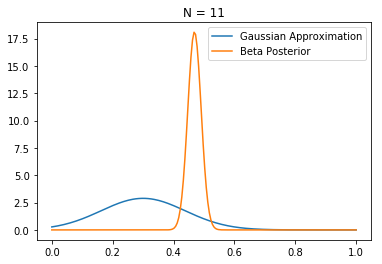

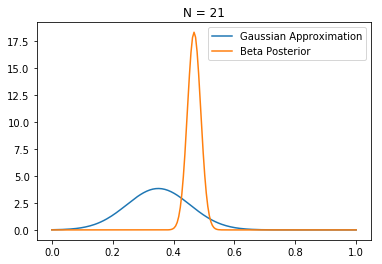

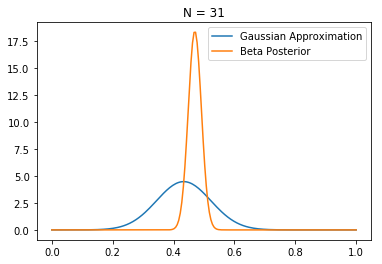

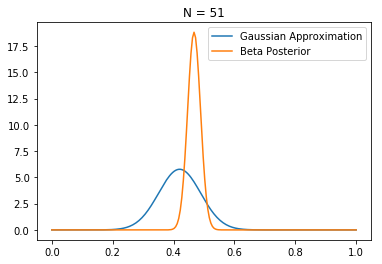

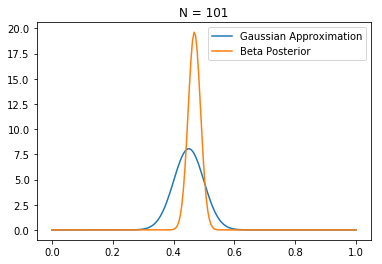

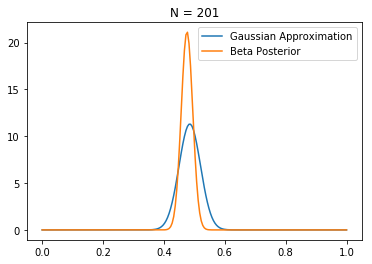

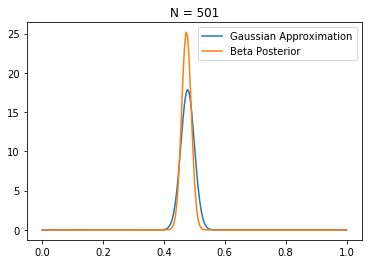

In [37]:
for i in range(T):
    x = 1 if np.random.random() < true_ctr else 0
    data[i] = x
    
    a+=x
    b+=(1-x)
    
    if i in plot_indecies:
        p = data[:i].mean()
        n = i+1
        std = np.sqrt(p*(1-p)/n)
        
        x = np.linspace(0,1,200)
        g = norm.pdf(x, loc=p, scale=std)
        
        plt.plot(x, g, label="Gaussian Approximation")
        
        posteriar = beta.pdf(x, a=a,b=b)
        plt.plot(x, posteriar, label="Beta Posterior")
        plt.legend()
        plt.title("N = %s" % n)
        plt.show()